# Assignment 2 Stochastic Simulation - Discrete Event Simulation 

In this assignment we will use the following notation:
- $\lambda$ - the arrival rate into the system.
- $\mu$ - the capacity of eaach of $\textit{n}$ equal servers.
- $\rho$ - the system load. In a single server system, it will be 
$\rho = \frac{\lambda}{\mu}$. In a multi-server system (one queue with $\textit{n}$ equal servers, each with capacity $\mu$), it will be $\rho = \frac{\lambda}{n \mu}$

The mean waiting time for an M/M/1 queuing system is defined by:

$$
E(W) = E(s) - \frac{1}{\mu} = \frac{\frac{\rho}{\mu}}{1 - \rho}
$$

where $ p = \frac{\lambda}{\mu} $

The mean waiting time for an M/M/n queuing system is defined by:

$$
E(W) = \Pi_W \cdot \frac{1}{1 - \rho} \cdot \frac{1}{n \mu}
$$

where \( n \) is defined as the number of servers that are available and $ p = \frac{\lambda}{n \mu} $

In the case of multiple servers, the probability that all servers are full has to be taken into account. 
This is defined as:

$$
\Pi_W = \rho_n + \rho_{n+1} + \rho_{n+2} + \cdots = \frac{\rho_{c}}{1 - \rho}
$$

To see that the average waiting times are shorter for an M/M/n system, we will look at the specific case of M/M/2.

In this case, $n = 2$, so $\rho = \frac{\lambda}{2\mu}$

In an M/M/n system, the equilibrium probabilities are given by:

$P_n = \frac{(pn)^n}{n!}P_0$ for $n \leq c$

For the comparison of waiting times, we are interested in $P_2$, as waiting times occur in this scenario.
$$
\begin{array}{l}
- P_0 = P_0, \quad \text{Probability that there are no customers in the system,} \\
- P_1 = \rho P_0, \quad \text{Probability that 1 server is busy,} \\
- P_2 = \frac{\rho^2}{2} P_0, \quad \text{Probability that both servers are busy.}
\end{array}
$$

The normalization condition requires:
$$
P_0 + P_1 + P_2 = 1.
$$

Substitute these into the normalization condition:
$$
P_0 + \rho P_0 + \frac{\rho^2}{2} P_0 = 1.
$$

#### Solving for $P_0$
Factor out $P_0$:
$$
P_0 \left(1 + \rho + \frac{\rho^2}{2}\right) = 1.
$$

Solve for $P_0$:
$$
P_0 = \frac{1}{1 + \rho + \frac{\rho^2}{2}}.
$$

#### Substituting $P_0$ into $P_2$
Using the formula for $P_2$:
$$
P_2 = \frac{\rho^2}{2} P_0.
$$

Substitute $P_0 = \frac{1}{1 + \rho + \frac{\rho^2}{2}}$:
$$
P_2 = \frac{\rho^2 / 2}{1 + \rho + \frac{\rho^2}{2}}.
$$

Expand $\Pi_W$ for $M/M/2$:

$$
\Pi_W = P_2 = \frac{\rho^2 / 2}{1 + \rho + \rho^2 / 2}.
$$

Substitute $\Pi_W$ into $E(W)_{M/M/2}$:

$$
E(W)_{M/M/2} = \frac{\rho^2 / 2}{1 + \rho + \rho^2 / 2} \cdot \frac{1}{1 - \rho} \cdot \frac{1}{2\mu}.
$$

Simplifying yields:

$$
E(W)_{M/M/2} = \frac{\rho^2 / 2}{\left(1 + \rho + \frac{\rho^2}{2}\right) \cdot (1 - \rho) \cdot 4\mu},
$$


When comparing this with the waiting time for an M/M/1 system: 

$$
E(W)_{M/M/1} = \frac{\rho / \mu}{1 - \rho}
$$

The denominator of $E(W)_{M/M/2}$ is smaller than $E(W)_{M/M/1}$ because $\rho \leq 1$. And even though the nominator of $E(W)_{M/M/2}$ grows faster than the nominator of $E(W)_{M/M/1}$, the halving of the traffic intensity for $M/M/2$, yields to lower average waiting times for an $M/M/2$ queuing system, which can be generalized $to M/M/n$ systems.

### Non-mathematical explanation:

The M/M/2 system has shorter average waiting times than the M/M/1 system due to the workload being divided between two servers, leading to reduced queues and a higher overall efficiency in serving customers.

In [2]:
import numpy 
import simpy
from random import seed
from scipy.stats import t
from scipy.stats import ttest_ind
import random
import statistics
import matplotlib.pyplot as plt

In [3]:
number_of_servers = [1,2,4]
server_types = ["Deterministic", "Hyperexponential", "Markovian"]

def simulate_mmn( mean_interarrival, mean_service_time, n, simulation_time, measurement_time_interval, random_seed, service_type):
    random.seed(random_seed)

    waitingTimes = []
    serviceTimes = []
    interarrivalTimes = []
    queue_lengths = []
    timestamps = []
    num_customers_in_system = []
    time_in_system  = [] 

    def generator(env, interval, server):  # customer generator with interarrival times.
        """generator generates customers randomly"""
        while True:
            service_time = get_service_time(service_type, mean_service_time)
            c = customer(env, f'Customer_{env.now:.2f}', server, service_time=service_time)
            env.process(c)
            t = random.expovariate(1.0/ interval)
            interarrivalTimes.append(t)
            yield env.timeout(t)  # adds time to the counter, does not delete from the memory

    def customer(env, name, server, service_time):
        # customer arrives to the system, waits and leaves
        arrive = env.now
        #print('%7.4f : Arrival time of %s' % (arrive, name))
        with server.request() as req:
            queue_entry_time = env.now
            results = yield req | env.timeout(arrive)
            
            if req in results:
                queue_time = env.now - queue_entry_time
                waitingTimes.append(queue_time)
                servertime = service_time
                yield env.timeout(servertime)
                serviceTimes.append(servertime)
                total_time_in_sysytem = queue_time + servertime
                time_in_system.append(total_time_in_sysytem)
            else:
                waiting_time = env.now - queue_entry_time
                #waitingTimes.append(waiting_time)
       
    def monitor(env, server):
        while True:
            total_customers = len(server.queue) + (server.count)  # Customers in queue + cur served
            num_customers_in_system.append(total_customers)
            queue_lengths.append(len(server.queue))
            timestamps.append(env.now)
            yield env.timeout(measurement_time_interval)

    
    
    def get_service_time(service_type, mean_service_time):
        if service_type == "Deterministic":
            return mean_service_time
        elif service_type == "Hyperexponential":
            a = 2.0
            b = 10.0
            if .75*a + .25*b != mean_service_time: 
                raise ValueError("means not the same")
            if random.random() < 0.75:
                return random.expovariate(1.0 / a)  # mean = 1.0
            else:
                return random.expovariate(1.0 / b)  # mean = 5.0

        else:  # Exponential (M/M/n)
            return random.expovariate(1.0 / mean_service_time)

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=n)  # capacity changes the number of generators in the system.
    env.process(generator(env, mean_interarrival, server))
    env.process(monitor(env, server))
    env.run(until=simulation_time)
    #interarrivalTimes.append(interarrival)

    dimension = int(simulation_time / measurement_time_interval)
    queue_lengths_matrix = numpy.array(queue_lengths[:dimension])

    average_interarrival = statistics.mean(interarrivalTimes)
    average_waitingTime = statistics.mean(waitingTimes) if waitingTimes else 0
    average_serviceTime = statistics.mean(serviceTimes)
    return {
        "servers": n,
        "average_interarrival": average_interarrival,
        "average_waitingTime": average_waitingTime,
        "average_serviceTime": average_serviceTime,
        "queue_lengths_matrix" : queue_lengths_matrix,
        "timestamps" : timestamps, 
        "customers_in_system": num_customers_in_system, 
        "system_time" : time_in_system


    }

def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = numpy.mean(data)
    std_err = numpy.std(data, ddof=1) / numpy.sqrt(n)
    t_value = t.ppf((1+ confidence)/2, df=n-1)
    return mean, mean - t_value * std_err, mean + t_value * std_err  

system_load = .95 # Rho
mean_service_time = 4
simulations = 300
servers = [1,2,4]
simulation_time = 2000
measurement_time_interval = 5
random.seed(33)

service_rate = 1/mean_service_time
mean_interarrival_by_n = {n: 1 / (n*system_load * service_rate) for n in servers}

results = {
    "Deterministic": {1: [], 2: [], 4: []},
    "Hyperexponential": {1: [], 2: [], 4: []},
    "Markovian": {1: [], 2: [], 4: []},
}
queue_length_matrices  = {stype: {n: [] for n in servers} for stype in server_types}
waiting_times_matrices  = {
    "Deterministic": {1: [], 2: [], 4: []},
    "Hyperexponential": {1: [], 2: [], 4: []},
    "Markovian": {1: [], 2: [], 4: []},
}
time_data = {stype: {n: [] for n in servers} for stype in server_types}
system_time =  {
    "Deterministic": {1: [], 2: [], 4: []},
    "Hyperexponential": {1: [], 2: [], 4: []},
    "Markovian": {1: [], 2: [], 4: []}}
customers_system  = {stype: {n: [] for n in servers} for stype in server_types}


for server_type in server_types: 
    for n in servers:
        mean_interarrival = mean_interarrival_by_n[n]
        for _ in range(simulations):
            random_seed = random.randint(0,10000)
            result = simulate_mmn( mean_interarrival, mean_service_time, n, simulation_time, measurement_time_interval, random.randint(0,1000), server_type)
            results[server_type][n].append(result['average_waitingTime'])
            queue_length_matrices[server_type][n].append(result['queue_lengths_matrix'])
            time_data[server_type][n].append(result['timestamps'])
            system_time[server_type][n].append(result["average_serviceTime"] + result["average_waitingTime"])
            customers_system[server_type][n].append(result["customers_in_system"])


print("\nSimulation results for n=1, 2, and 4 with Confidence Intervals:\n")
for server_type in server_types:
    print(f"\nTesting for server type {server_type}\n")
    for n in servers:
        mean, ci_lower, ci_upper = confidence_interval(results[server_type][n])  #
        print(
            f"Servers: {n}, "
            f"Mean Waiting Time: {mean:.4f}, "
            f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})"
        )


Simulation results for n=1, 2, and 4 with Confidence Intervals:


Testing for server type Deterministic

Servers: 1, Mean Waiting Time: 26.1940, 95% CI: (24.5654, 27.8227)
Servers: 2, Mean Waiting Time: 17.1668, 95% CI: (15.7803, 18.5534)
Servers: 4, Mean Waiting Time: 7.4766, 95% CI: (7.2150, 7.7382)

Testing for server type Hyperexponential

Servers: 1, Mean Waiting Time: 58.4041, 95% CI: (53.1031, 63.7050)
Servers: 2, Mean Waiting Time: 34.1908, 95% CI: (31.9932, 36.3885)
Servers: 4, Mean Waiting Time: 20.6035, 95% CI: (19.1031, 22.1040)

Testing for server type Markovian

Servers: 1, Mean Waiting Time: 42.0284, 95% CI: (39.6712, 44.3855)
Servers: 2, Mean Waiting Time: 27.6035, 95% CI: (25.1396, 30.0673)
Servers: 4, Mean Waiting Time: 12.4227, 95% CI: (11.7549, 13.0906)


In [4]:
for servertype in server_types: 
    print(f"\ntesting for {servertype}\n ")
    t_stat_1, p_value_1 = ttest_ind(results[server_type][1], results[server_type][2], equal_var=False)
    print(f"T-statistic: {t_stat_1:.4f}, P-value: {p_value_1:.4f}")

    if p_value_1 < 0.05:
        print("Result is statistically significant and we can reject H0 that the mean waiting time between n=1 and n=2 does not differ significantly.")
    else:
        print("Result is not statistically significant and we fail to reject H0 (1,2)")

    t_stat_2, p_value_2 = ttest_ind(results[server_type][2], results[server_type][4], equal_var=False)
    print(f"T-statistic: {t_stat_2:.4f}, P-value: {p_value_2:.4f}")

    if p_value_2 < 0.05:
        print("The result is statistically significant and the null hypotheses that the mean waiting time of groups n=2 and n=4 do not differ significantly, is rejected")
    else:
        print("Result is not statistically significant and we cannot reject H0 (2,4)")

    t_stat_3, p_value_3 = ttest_ind(results[server_type][1], results[server_type][4], equal_var=False)
    print(f"T-statistic: {t_stat_3:.4f}, P-value: {p_value_3:.4f}")

    if p_value_3 < 0.05:
        print("The result is statistically significant and the null hypotheses that the mean waiting time of groups n=1 and n=4 do not differ significantly, is rejected")
    else:
        print("Result is not statistically significant and we cannot reject H0 (1,4)" )


testing for Deterministic
 
T-statistic: 8.3251, P-value: 0.0000
Result is statistically significant and we can reject H0 that the mean waiting time between n=1 and n=2 does not differ significantly.
T-statistic: 11.7029, P-value: 0.0000
The result is statistically significant and the null hypotheses that the mean waiting time of groups n=2 and n=4 do not differ significantly, is rejected
T-statistic: 23.7807, P-value: 0.0000
The result is statistically significant and the null hypotheses that the mean waiting time of groups n=1 and n=4 do not differ significantly, is rejected

testing for Hyperexponential
 
T-statistic: 8.3251, P-value: 0.0000
Result is statistically significant and we can reject H0 that the mean waiting time between n=1 and n=2 does not differ significantly.
T-statistic: 11.7029, P-value: 0.0000
The result is statistically significant and the null hypotheses that the mean waiting time of groups n=2 and n=4 do not differ significantly, is rejected
T-statistic: 23.780

In [5]:

def compare_littles_law(results):
    print("\nComparing Little's Law:\n")
    for server_type in server_types:
        print(f"Server Type: {server_type}")
        for n in servers:
            # results
            avg_waiting_time = numpy.mean(results[server_type][n]) 
            avg_interarrival_time = mean_interarrival_by_n[n]  # arrival rate 
            avg_service_time = mean_service_time  
            
            #Little
            lambda_rate = 1 / avg_interarrival_time  # arrival rate
            avg_total_waiting_time = avg_waiting_time + avg_service_time  
            littles_L = lambda_rate * avg_total_waiting_time  # L = λ * W
            
            # measure L from simulation 
            avg_L_simulation = numpy.mean([numpy.mean(queue) for queue in customers_system[server_type][n]])

            print(f"  servers: {n}")
            print(f"    simulation results -> L = {avg_L_simulation:.4f}")
            print(f"    Little's law -> L =  {littles_L:.4f}")
            print(f"    difference: {abs(avg_L_simulation - littles_L):.4f} \n")
            
compare_littles_law(results)



Comparing Little's Law:

Server Type: Deterministic
  servers: 1
    simulation results -> L = 7.2627
    Little's law -> L =  7.1711
    difference: 0.0916 

  servers: 2
    simulation results -> L = 10.1673
    Little's law -> L =  10.0543
    difference: 0.1130 

  servers: 4
    simulation results -> L = 10.9234
    Little's law -> L =  10.9028
    difference: 0.0206 

Server Type: Hyperexponential
  servers: 1
    simulation results -> L = 14.4295
    Little's law -> L =  14.8210
    difference: 0.3915 

  servers: 2
    simulation results -> L = 18.1862
    Little's law -> L =  18.1407
    difference: 0.0455 

  servers: 4
    simulation results -> L = 23.6113
    Little's law -> L =  23.3734
    difference: 0.2379 

Server Type: Markovian
  servers: 1
    simulation results -> L = 10.8396
    Little's law -> L =  10.9317
    difference: 0.0921 

  servers: 2
    simulation results -> L = 15.1023
    Little's law -> L =  15.0117
    difference: 0.0906 

  servers: 4
    simulat

In [6]:
# params
rho_vals = [.001, .01, .1, .2, .3, .4, .5, .6, .7, .8, .9, .99]
servers = [1, 2, 4]
simulations = 10


wts = {"Deterministic":{n: [[] for _ in rho_vals] for n in servers}, "Hyperexponential":{n: [[] for _ in rho_vals] for n in servers}, "Markovian":{n: [[] for _ in rho_vals] for n in servers}}


In [7]:

for server_type in server_types: 
# simmulate 
    for i, rho in enumerate(rho_vals):
        # calculate mean 
        mean_interarrival_by_n = {n: 1 / (n * rho * service_rate) for n in servers}
        
        for sim in range(simulations):
            for n in servers:
                mean_interarrival = mean_interarrival_by_n[n]
                # Simulate + sore 
                wt = simulate_mmn(mean_interarrival, mean_service_time, n, 201, measurement_time_interval, random.randint(0,1000), server_type)
                (wts[server_type])[n][i].append(wt["average_waitingTime"])



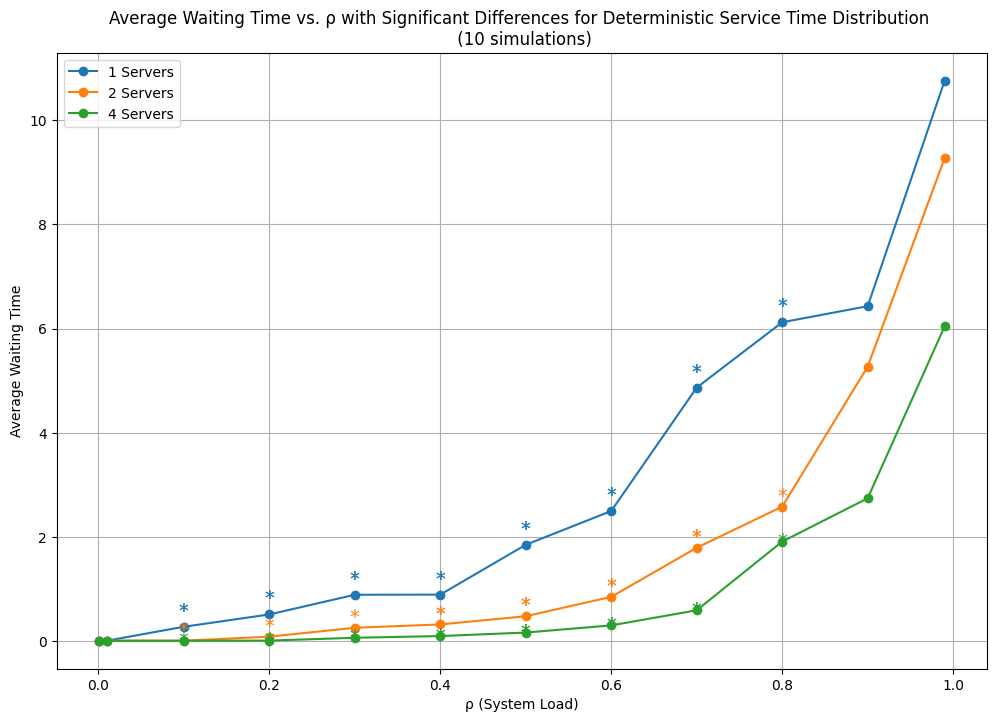

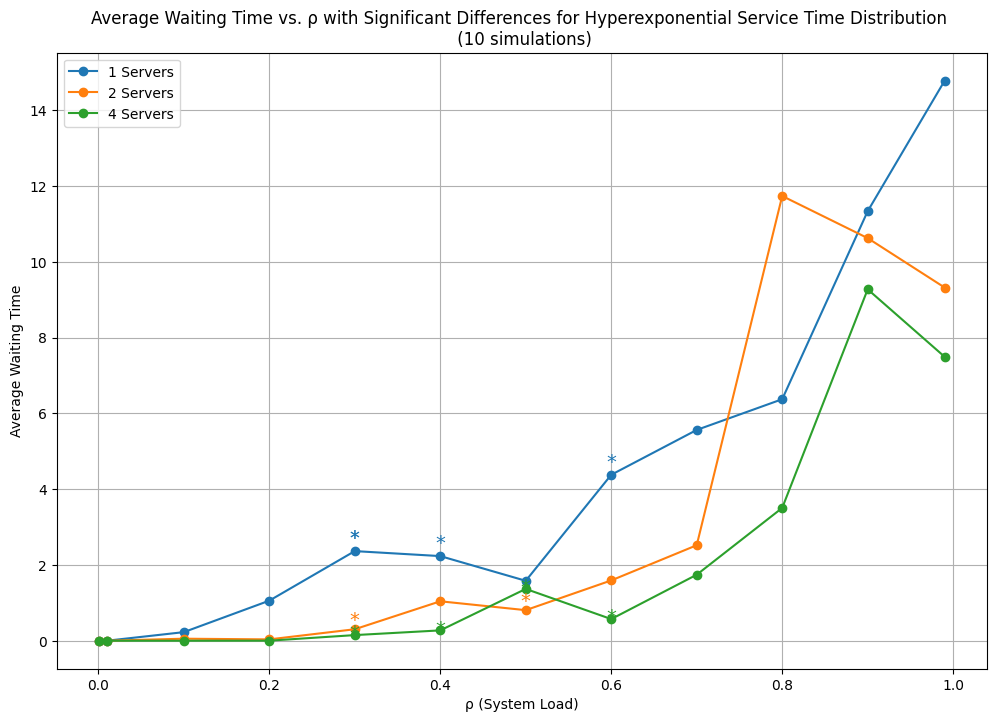

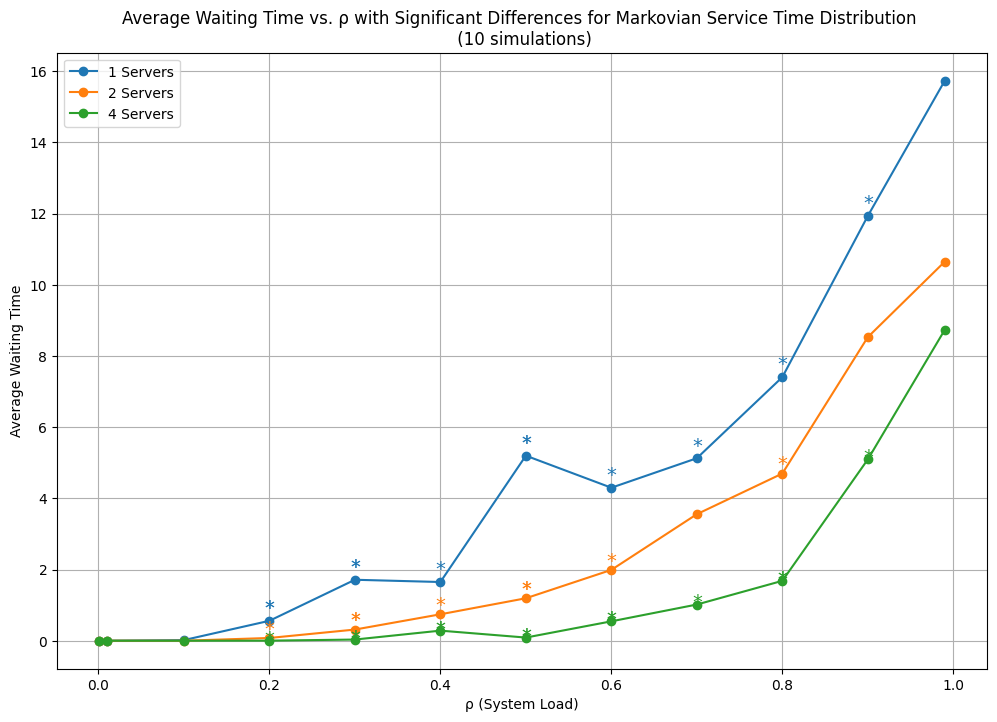

In [8]:

alpha = 0.05
offset = 0.3

for server_type in server_types:
    average_waiting_times = {
        n: [numpy.mean(wts[server_type][n][i]) for i in range(len(rho_vals))]
        for n in servers
    }

    significant_points = {n: [] for n in servers}

    for i, rho in enumerate(rho_vals):
        waiting_times = {n: wts[server_type][n][i] for n in servers}
        
        for n1 in servers:
            for n2 in servers:
                if n1 < n2:
                    t_stat, p_val = ttest_ind(waiting_times[n1], waiting_times[n2], equal_var=False)
                    if p_val < alpha:
                        significant_points[n1].append(rho)
                        significant_points[n2].append(rho)

    plt.figure(figsize=(12, 8))

    line_colors = {}

    for n in servers:
        line, = plt.plot(rho_vals, average_waiting_times[n], label=f"{n} Servers", marker='o')
        line_colors[n] = line.get_color()

    for n in servers:
        for rho in significant_points[n]:
            y_value = average_waiting_times[n][rho_vals.index(rho)]
            plt.annotate(
                '*', 
                (rho, y_value + offset - n / 10),
                color=line_colors[n], 
                fontsize=14, 
                ha='center'
            )

    plt.title(f"Average Waiting Time vs. ρ with Significant Differences for {server_type} Service Time Distribution \n ({simulations} simulations)")
    plt.xlabel("ρ (System Load)")
    plt.ylabel("Average Waiting Time")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"rhoplot_{server_type}", dpi = 300)
    plt.show()


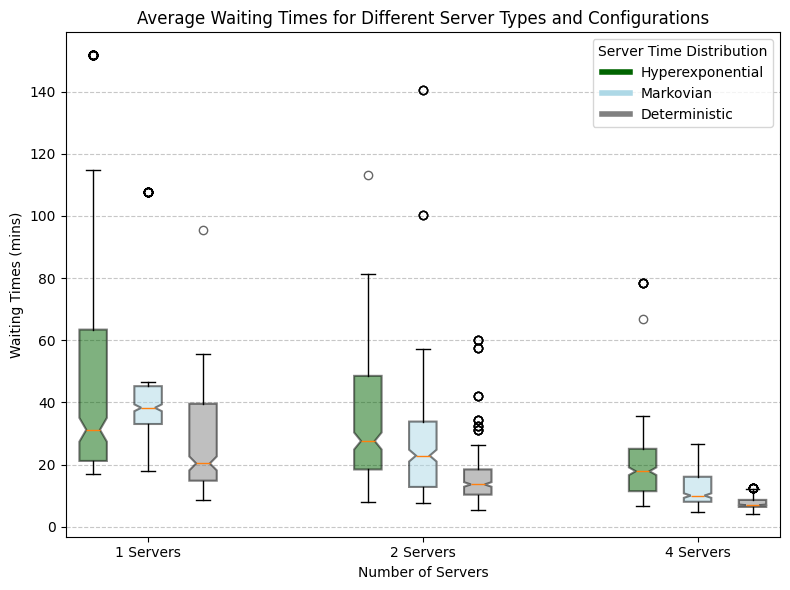

In [14]:
import matplotlib.pyplot as plt

colors = ['darkgreen', 'lightblue', 'gray']
group_positions = [1, 2, 3] 
server_types = ["Hyperexponential", "Markovian", "Deterministic"]
plt.figure(figsize=(8, 6))

all_waiting_times = []

spacing_between_groups = 5

for n in [1, 2, 4]:
    group_data = [results[servertype][n] for servertype in server_types]
    all_waiting_times.extend(group_data)

positions = []
for i, n in enumerate([1, 2, 4]):
    positions.extend([group + spacing_between_groups * i for group in group_positions])

bp = plt.boxplot(
    all_waiting_times,
    positions=positions,
    patch_artist=True,
    notch=True,
    boxprops=dict(linewidth=1.5),
    flierprops=dict(marker='o', color='red', alpha=0.6, markersize=6)
)

for patch, color in zip(bp["boxes"], colors * len([1, 2, 4])):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

# Add legend for server time distribution
legend_patches = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
plt.legend(legend_patches, server_types, title="Server Time Distribution", loc="upper right")

# Set x-ticks to only show the number of servers
unique_positions = [positions[i * len(server_types) + 1] for i in range(len([1, 2, 4]))]
labels = [f"{n} Servers" for n in [1, 2, 4]]
plt.xticks(unique_positions, labels)

plt.title("Average Waiting Times for Different Server Types and Configurations")
plt.ylabel("Waiting Times (mins)")
plt.xlabel("Number of Servers")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("boxplot2_4")
plt.show()

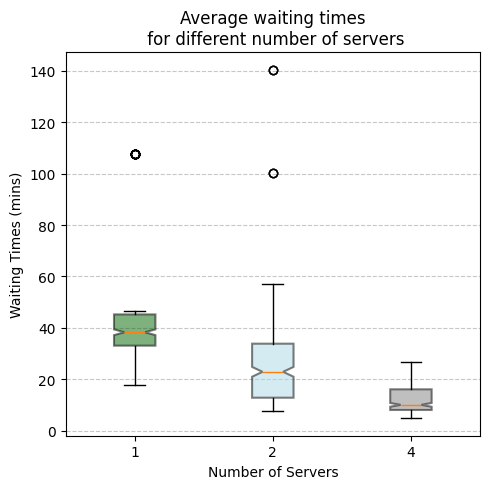

In [ ]:
colors = ['darkgreen', 'lightblue', 'gray']  # Custom colors for each configuration
server_type = "Markovian"
average_waiting_times = [results[server_type][n] for n in [1,2,4]]

plt.figure(figsize=(5, 5))

boxprops = dict(patch_artist=True, notch=True, linewidth=1.5)
bp = plt.boxplot(
    average_waiting_times, 
    labels=["1", "2", "4"], 
    patch_artist=True,
    notch=True, 
    boxprops=dict(linewidth=1.5),
)

for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

plt.title("Average waiting times\n for different number of servers")
plt.ylabel("Waiting Times (mins)")
plt.xlabel("Number of Servers")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for flier in bp['fliers']:
    flier.set(marker='o', color='red', alpha=0.6, markersize=6)
plt.tight_layout()
plt.savefig("boxplot2", dpi = 300)
plt.show()

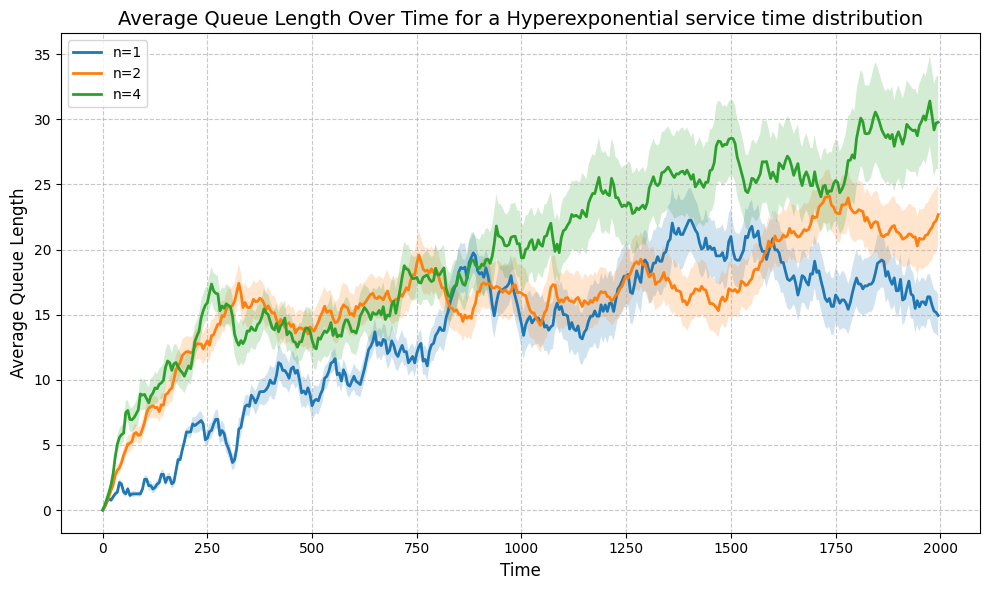

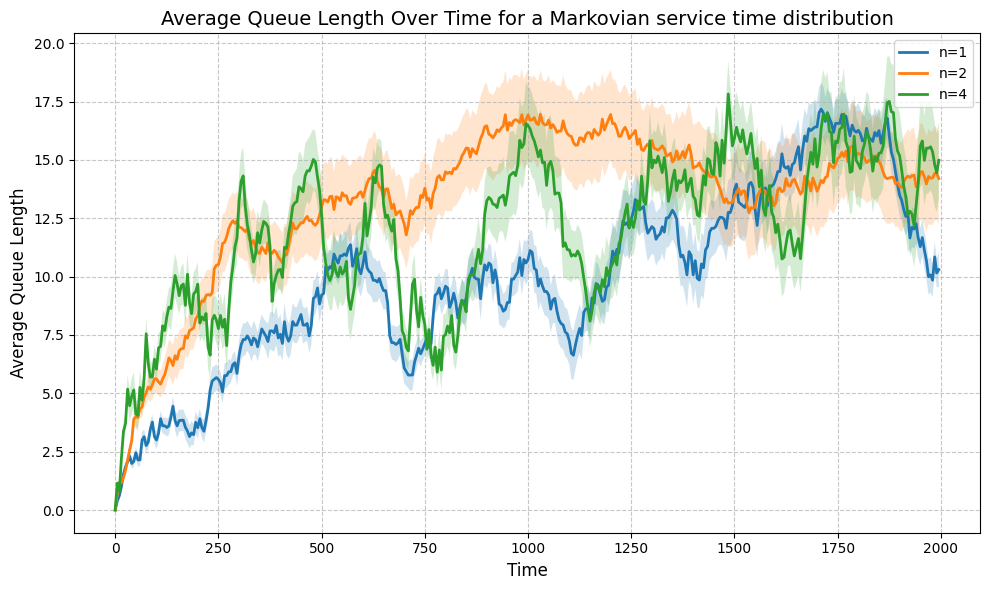

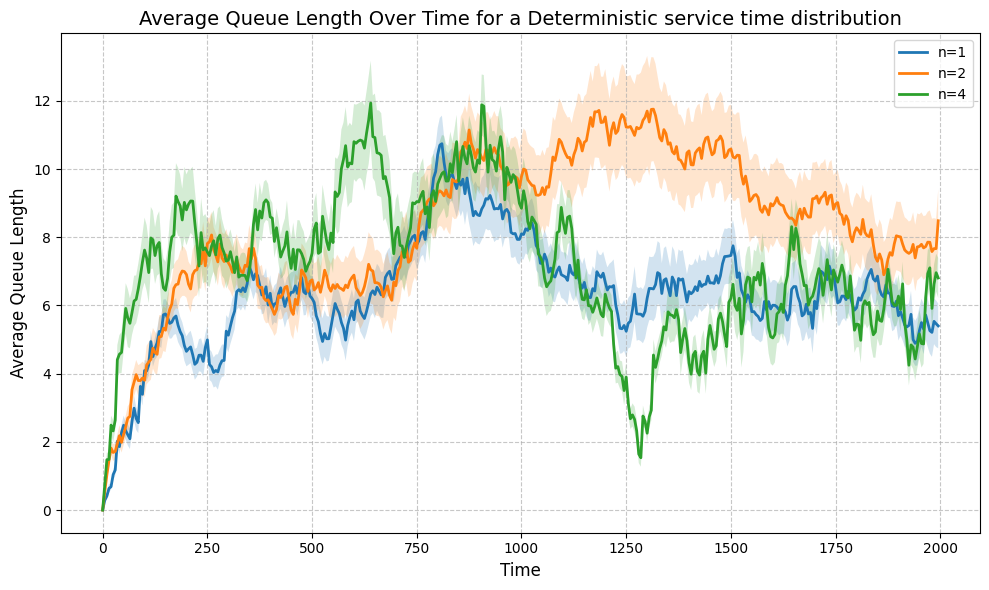

In [ ]:
colors = ["seagreen", "cornflowerblue", "darkorange"] 

import numpy as np
for server_type in server_types: 
    plot_data = {}
    for n, q_lengths_matrix in queue_length_matrices[server_type].items():
        q_lengths_matrix = np.array(q_lengths_matrix)
        averages = np.mean(q_lengths_matrix, axis=0)
        std_dev = np.std(q_lengths_matrix, axis=0, ddof=1)
        ci_lower = averages - 1.96 * std_dev / np.sqrt(q_lengths_matrix.shape[0])
        ci_upper = averages + 1.96 * std_dev / np.sqrt(q_lengths_matrix.shape[0])

        time_steps = np.arange(q_lengths_matrix.shape[1]) * measurement_time_interval 


        plot_data[n] = {
                "time_steps": time_steps,
                "averages": averages,
                "ci_lower": ci_lower,
                "ci_upper": ci_upper
            }


    plt.figure(figsize=(10, 6))
    for n in plot_data:
        time_steps = plot_data[n]["time_steps"]
        averages = plot_data[n]["averages"]
        ci_lower = plot_data[n]["ci_lower"]
        ci_upper = plot_data[n]["ci_upper"]


        #plottre
        plt.plot(time_steps, averages, label=f'n={n}', linewidth=2)
        plt.fill_between(time_steps, ci_lower, ci_upper, alpha=0.2)

    plt.title(f"Average Queue Length Over Time for a {server_type} service time distribution", fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Average Queue Length", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


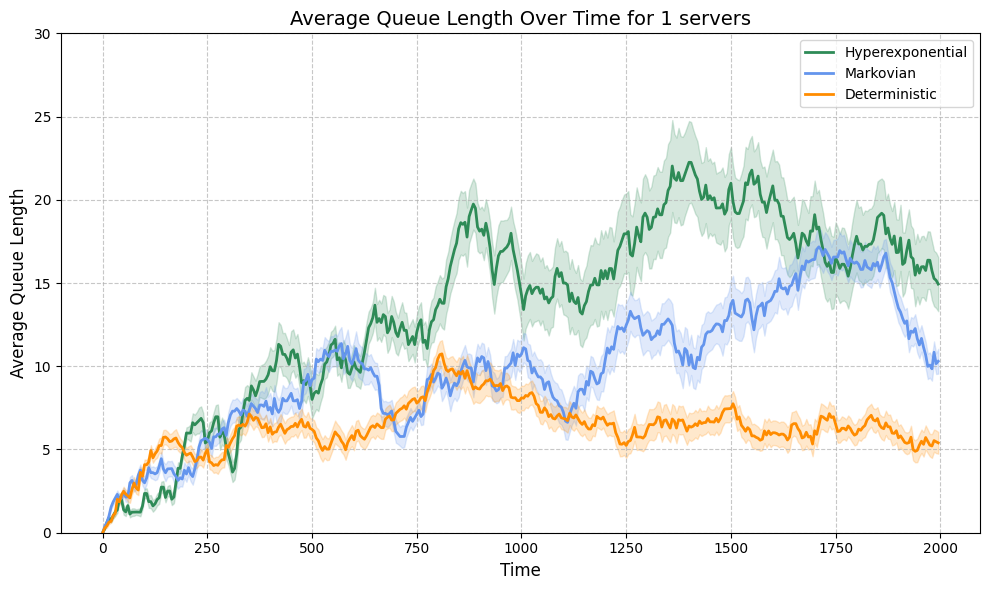

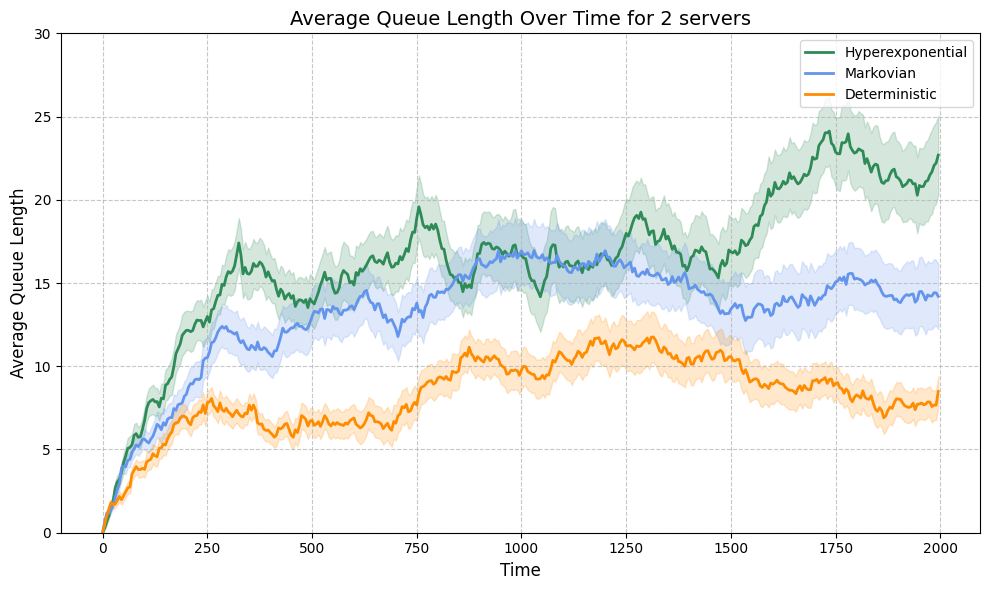

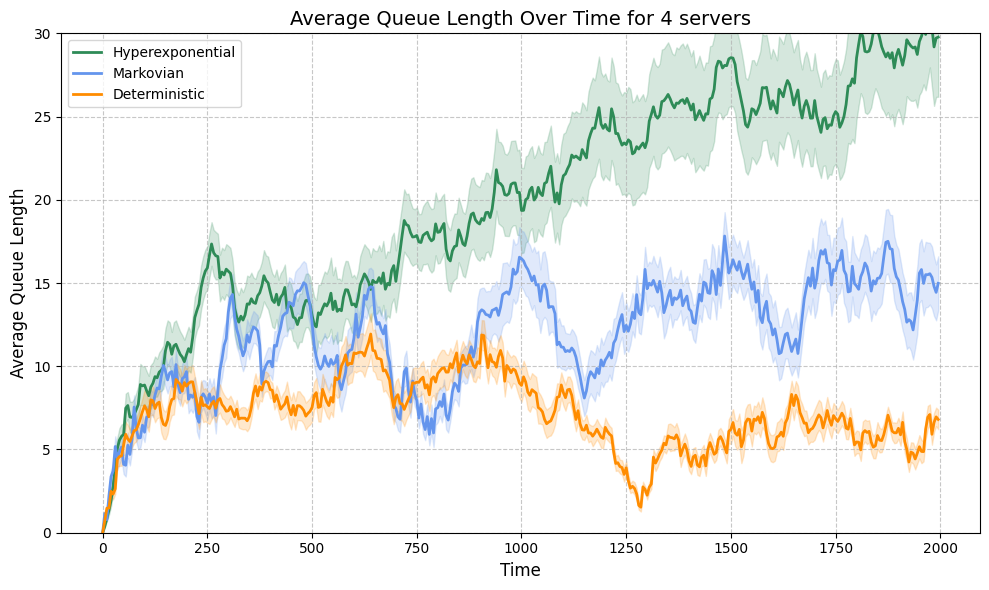

In [ ]:

for n in number_of_servers: 
    plt.figure(figsize=(10, 6))
    for server_type in server_types:
        plot_data = {}
        q_lengths_matrix = np.array(queue_length_matrices[server_type][n])
        averages = np.mean(q_lengths_matrix, axis=0)
        std_dev = np.std(q_lengths_matrix, axis=0, ddof=1)
        ci_lower = averages - 1.96 * std_dev / np.sqrt(q_lengths_matrix.shape[0])
        ci_upper = averages + 1.96 * std_dev / np.sqrt(q_lengths_matrix.shape[0])

        time_steps = np.arange(q_lengths_matrix.shape[1]) * measurement_time_interval 

        plot_data[server_type] = {
            "time_steps": time_steps,
            "averages": averages,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper
        }

        time_steps = plot_data[server_type]["time_steps"]
        averages = plot_data[server_type]["averages"]
        ci_lower = plot_data[server_type]["ci_lower"]
        ci_upper = plot_data[server_type]["ci_upper"]

        # plotter
        plt.plot(time_steps, averages, label=f'{server_type}', linewidth=2, color = colors[server_types.index(server_type)])
        plt.fill_between(time_steps, ci_lower, ci_upper, alpha=0.2, color = colors[server_types.index(server_type)])
    plt.title(f"Average Queue Length Over Time for {n} servers", fontsize=14)
    plt.ylim(0,30)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Average Queue Length", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"final_opdr4_{n}_servers.png", dpi=300)

    plt.show()



## SJF model

In [ ]:


server_types = ["Deterministic", "Hyperexponential", "Markovian"]

def simulate_mmn_sjf(mean_interarrival, mean_service_time, n, simulation_time, measurement_time_interval, random_seed, service_type):
    random.seed(random_seed)

    waiting_times = []
    service_times = []
    interarrival_times = []
    queue_lengths = []
    num_customers_in_system = []
    timestamps = []

    def generator(env, interval, server):
        while True:
            service_time = get_service_time(service_type, mean_service_time)
            priority = service_time  # Priority based on service time 
            c = customer(env, f'Customer_{env.now:.2f}', server, service_time=service_time, priority=priority)
            env.process(c)
            t = random.expovariate(1.0 / interval)
            interarrival_times.append(t)
            yield env.timeout(t)

    def customer(env, name, server, service_time, priority):
        arrive = env.now
        with server.request(priority=priority) as req:  # Request with priority
            queue_entry_time = env.now
            results = yield req | env.timeout(arrive)

            if req in results:
                queue_time = env.now - queue_entry_time
                waiting_times.append(queue_time)
                yield env.timeout(service_time)
                service_times.append(service_time)
            else:
                waiting_time = env.now - queue_entry_time

    def monitor(env, server):
        while True:
            total_customers = len(server.queue) + (server.count)  # Customers in queue + being served
            num_customers_in_system.append(total_customers)

            queue_lengths.append(len(server.queue))
            timestamps.append(env.now)
            yield env.timeout(measurement_time_interval)

    def get_service_time(service_type, mean_service_time):
        if service_type == "Deterministic":
            return mean_service_time
        elif service_type == "Hyperexponential":
            a = 2.0
            b = 10.0
            if .75 * a + .25 * b != mean_service_time:
                raise ValueError("means not the same")
            if random.random() < 0.75:
                return random.expovariate(1.0 / a)
            else:
                return random.expovariate(1.0 / b)
        else:  # Exponential (M/M/n)
            return random.expovariate(1.0 / mean_service_time)

    env = simpy.Environment()
    server = simpy.PriorityResource(env, capacity=n)  # SJF
    env.process(generator(env, mean_interarrival, server))
    env.process(monitor(env, server))
    env.run(until=simulation_time)

    dimension = int(simulation_time / measurement_time_interval)
    queue_lengths_matrix = np.array(queue_lengths[:dimension])

    average_interarrival = statistics.mean(interarrival_times)
    average_waiting_time = statistics.mean(waiting_times) if waiting_times else 0
    average_service_time = statistics.mean(service_times)
    return {
        "servers": n,
        "average_interarrival": average_interarrival,
        "average_waiting_time": average_waiting_time,
        "average_service_time": average_service_time,
        "queue_lengths_matrix": queue_lengths_matrix,
        "timestamps": timestamps, 
        "customers_in_system": num_customers_in_system
    }


def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    t_value = t.ppf((1 + confidence) / 2, df=n - 1)
    return mean, mean - t_value * std_err, mean + t_value * std_err


system_load = 0.95
mean_service_time = 4
simulations = 300
servers = [1, 2, 4]
simulation_time = 2000
measurement_time_interval = 5
random.seed(33)

service_rate = 1 / mean_service_time
mean_interarrival_by_n = {n: 1 / (n * system_load * service_rate) for n in servers}

results_sjf = {
    "Deterministic": {1: [], 2: [], 4: []},
    "Hyperexponential": {1: [], 2: [], 4: []},
    "Markovian": {1: [], 2: [], 4: []},
}
queue_length_matrices_sjf = {stype: {n: [] for n in servers} for stype in server_types}
waiting_times_matrices_sjf = {
    "Deterministic": {1: [], 2: [], 4: []},
    "Hyperexponential": {1: [], 2: [], 4: []},
    "Markovian": {1: [], 2: [], 4: []},
}
time_data_sjf = {stype: {n: [] for n in servers} for stype in server_types}
customers_system_sjf  = {stype: {n: [] for n in servers} for stype in server_types}

for server_type in server_types:
    for n in servers:
        mean_interarrival = mean_interarrival_by_n[n]
        for _ in range(simulations):
            random_seed = random.randint(0, 10000)
            result_sjf = simulate_mmn_sjf(mean_interarrival, mean_service_time, n, simulation_time, measurement_time_interval, random.randint(0, 1000), server_type)
            results_sjf[server_type][n].append(result_sjf["average_waiting_time"])
            queue_length_matrices_sjf[server_type][n].append(result_sjf["queue_lengths_matrix"])
            time_data_sjf[server_type][n].append(result_sjf["timestamps"])
            customers_system_sjf[server_type][n].append(result_sjf["customers_in_system"])

print("\nSimulation results for n=1, 2, and 4 with Confidence Intervals (SJF):\n")
for server_type in server_types:
    print(f"\nTesting for server type {server_type}\n")
    for n in servers:
        mean, ci_lower, ci_upper = confidence_interval(results_sjf[server_type][n])
        print(
            f"Servers: {n}, "
            f"Mean Waiting Time: {mean:.4f}, "
            f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})"
        )



Simulation results for n=1, 2, and 4 with Confidence Intervals (SJF):


Testing for server type Deterministic

Servers: 1, Mean Waiting Time: 26.1940, 95% CI: (24.5654, 27.8227)
Servers: 2, Mean Waiting Time: 17.1668, 95% CI: (15.7803, 18.5534)
Servers: 4, Mean Waiting Time: 7.4766, 95% CI: (7.2150, 7.7382)

Testing for server type Hyperexponential

Servers: 1, Mean Waiting Time: 10.7605, 95% CI: (10.4763, 11.0447)
Servers: 2, Mean Waiting Time: 7.1286, 95% CI: (6.8956, 7.3617)
Servers: 4, Mean Waiting Time: 4.4510, 95% CI: (4.3078, 4.5942)

Testing for server type Markovian

Servers: 1, Mean Waiting Time: 12.2950, 95% CI: (11.9216, 12.6683)
Servers: 2, Mean Waiting Time: 7.2583, 95% CI: (7.0218, 7.4947)
Servers: 4, Mean Waiting Time: 3.9415, 95% CI: (3.7985, 4.0844)


In [ ]:
for servertype in server_types: 
    print(f"\ntesting for {servertype}\n ")
    t_stat_1, p_value_1 = ttest_ind(results_sjf[server_type][1], results_sjf[server_type][2], equal_var=False)
    print(f"T-statistic: {t_stat_1:.4f}, P-value: {p_value_1:.4f}")

    if p_value_1 < 0.05:
        print("Result is statistically significant and we can reject H0 that the mean waiting time between n=1 and n=2 does not differ significantly.")
    else:
        print("Result is not statistically significant and we fail to reject H0 (1,2)")

    t_stat_2, p_value_2 = ttest_ind(results_sjf[server_type][2], results_sjf[server_type][4], equal_var=False)
    print(f"T-statistic: {t_stat_2:.4f}, P-value: {p_value_2:.4f}")

    if p_value_2 < 0.05:
        print("The result is statistically significant and the null hypotheses that the mean waiting time of groups n=2 and n=4 do not differ significantly, is rejected")
    else:
        print("Result is not statistically significant and we cannot reject H0 (2,4)")

    t_stat_3, p_value_3 = ttest_ind(results_sjf[server_type][1], results_sjf[server_type][4], equal_var=False)
    print(f"T-statistic: {t_stat_3:.4f}, P-value: {p_value_3:.4f}")

    if p_value_3 < 0.05:
        print("The result is statistically significant and the null hypotheses that the mean waiting time of groups n=1 and n=4 do not differ significantly, is rejected")
    else:
        print("Result is not statistically significant and we cannot reject H0 (1,4)" )


testing for Deterministic
 
T-statistic: 22.4288, P-value: 0.0000
Result is statistically significant and we can reject H0 that the mean waiting time between n=1 and n=2 does not differ significantly.
T-statistic: 23.6237, P-value: 0.0000
The result is statistically significant and the null hypotheses that the mean waiting time of groups n=2 and n=4 do not differ significantly, is rejected
T-statistic: 41.1200, P-value: 0.0000
The result is statistically significant and the null hypotheses that the mean waiting time of groups n=1 and n=4 do not differ significantly, is rejected

testing for Hyperexponential
 
T-statistic: 22.4288, P-value: 0.0000
Result is statistically significant and we can reject H0 that the mean waiting time between n=1 and n=2 does not differ significantly.
T-statistic: 23.6237, P-value: 0.0000
The result is statistically significant and the null hypotheses that the mean waiting time of groups n=2 and n=4 do not differ significantly, is rejected
T-statistic: 41.1

In [ ]:
# Params
rho_vals = [.001, .01, .1, .2, .3, .4, .5, .6, .7, .8, .9, .99]
servers = [1, 2, 4]
simulations = 300


wts = {"Deterministic":{n: [[] for _ in rho_vals] for n in servers}, "Hyperexponential":{n: [[] for _ in rho_vals] for n in servers}, "Markovian":{n: [[] for _ in rho_vals] for n in servers}}


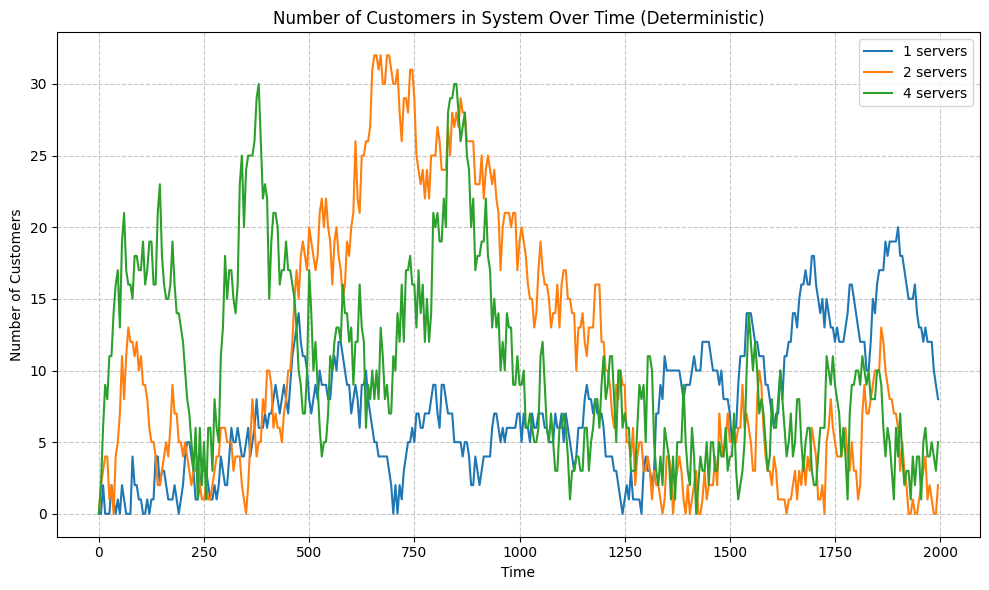

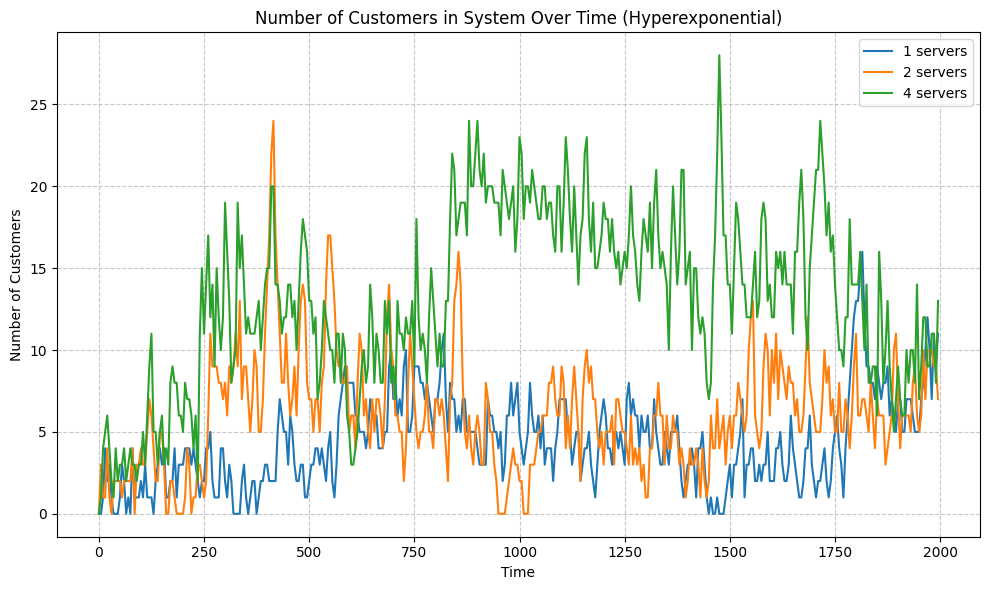

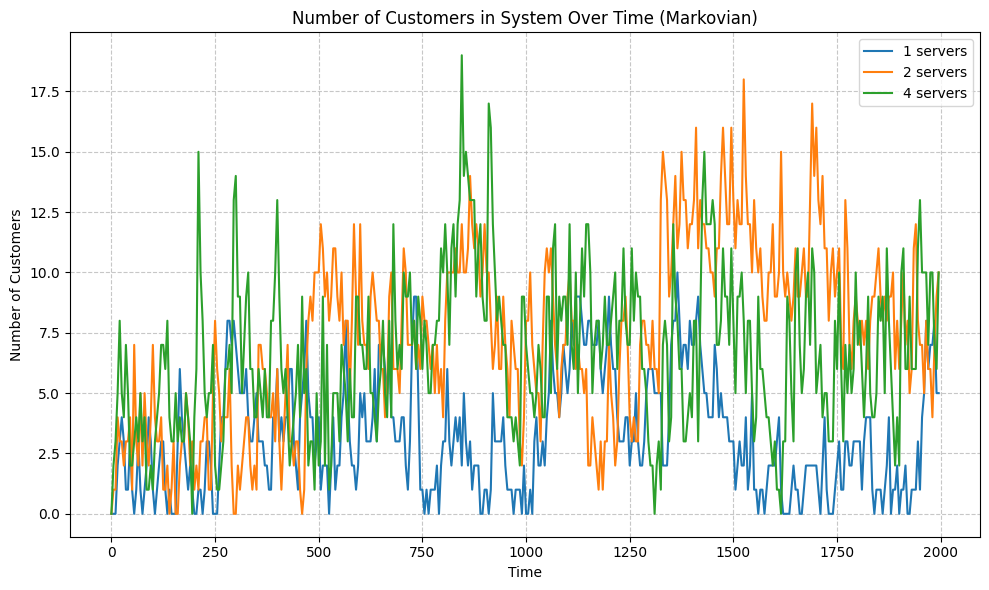

In [ ]:
for server_type in server_types:
    plt.figure(figsize=(10, 6))
    for n in servers:
        result = customers_system_sjf[server_type][n][0]
        time_steps = np.arange(q_lengths_matrix.shape[1]) * measurement_time_interval 

        
        plt.plot(time_steps, result, label=f"{n} servers")
    
    plt.title(f"Number of Customers in System Over Time ({server_type})")
    plt.xlabel("Time")
    plt.ylabel("Number of Customers")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [ ]:
system_load = 0.95
mean_service_time = 4
simulations = 300
servers = [1, 2, 4]
simulation_time = 2000
measurement_time_interval = 5
random.seed(33)

service_rate = 1 / mean_service_time
mean_interarrival_by_n = {n: 1 / (n * system_load * service_rate) for n in servers}

def compare_littles_law(results_sjf):
    print("\nComparing Little's Law:\n")
    for server_type in server_types:
        print(f"Server Type: {server_type}")
        for n in servers:
            #  results
            
            avg_waiting_time = np.mean(results_sjf[server_type][n])  
            avg_interarrival_time = mean_interarrival_by_n[n]  # arrival rate 
            avg_service_time = mean_service_time  
            
            lambda_rate = 1 / avg_interarrival_time  
            avg_total_waiting_time = avg_waiting_time + avg_service_time  
            littles_L = lambda_rate * avg_total_waiting_time  # L = λ * W
            
            avg_L_simulation = np.mean([np.mean(queue) for queue in customers_system_sjf[server_type][n]])

            print(f" servers: {n}")
            print(f"    simulation results -> L = {avg_L_simulation:.4f}")
            print(f"    little's law -> L =  {littles_L:.4f}")
            print(f"    difference: {abs(avg_L_simulation - littles_L):.4f} \n")

compare_littles_law(results_sjf)



Comparing Little's Law:

Server Type: Deterministic
 servers: 1
    simulation results -> L = 7.2627
    little's law -> L =  7.1711
    difference: 0.0916 

 servers: 2
    simulation results -> L = 10.1673
    little's law -> L =  10.0543
    difference: 0.1130 

 servers: 4
    simulation results -> L = 10.9234
    little's law -> L =  10.9028
    difference: 0.0206 

Server Type: Hyperexponential
 servers: 1
    simulation results -> L = 3.7136
    little's law -> L =  3.5056
    difference: 0.2080 

 servers: 2
    simulation results -> L = 5.5128
    little's law -> L =  5.2861
    difference: 0.2267 

 servers: 4
    simulation results -> L = 8.2812
    little's law -> L =  8.0285
    difference: 0.2527 

Server Type: Markovian
 servers: 1
    simulation results -> L = 4.0546
    little's law -> L =  3.8701
    difference: 0.1845 

 servers: 2
    simulation results -> L = 5.7003
    little's law -> L =  5.3477
    difference: 0.3526 

 servers: 4
    simulation results -> L = 

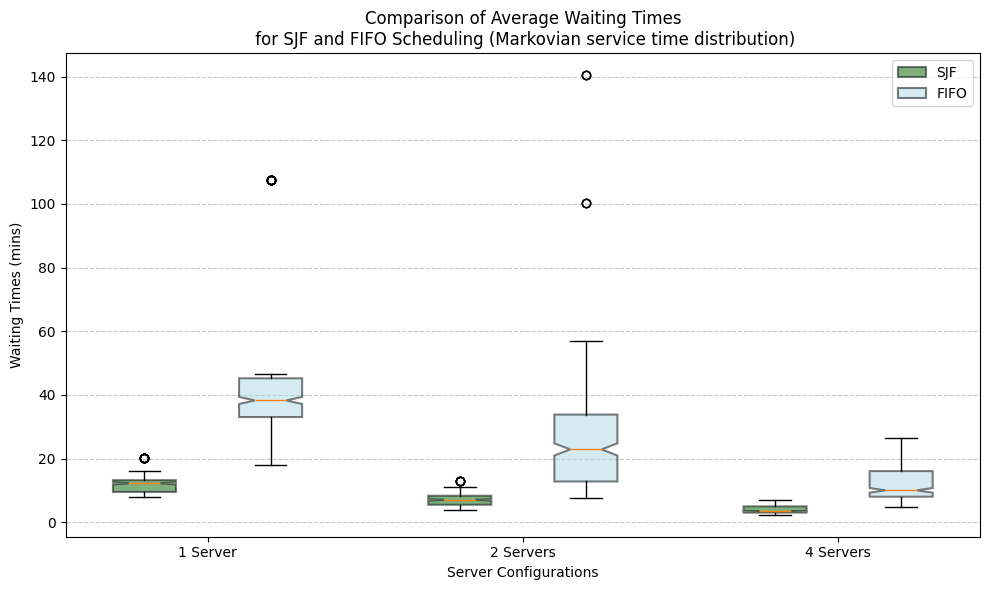

In [ ]:


colors = ['darkgreen', 'lightblue']  
server_type = "Markovian"

# extract data 
average_waiting_times_sjf = [
    results_sjf[server_type][n] for n in [1, 2, 4]
]
average_waiting_times_fifo = [
    results[server_type][n] for n in [1, 2, 4]
]  


plt.figure(figsize=(10, 6))

positions_sjf = [1, 3, 5]  # positions 

bp_sjf = plt.boxplot(
    average_waiting_times_sjf,
    positions=positions_sjf,
    patch_artist=True,
    notch=True,
    widths=0.4,
    boxprops=dict(linewidth=1.5),
    labels=[f"{n} Servers" for n in [1, 2, 4]],
    flierprops=dict(marker='o', color='red', alpha=0.6, markersize=6)
)

for patch in bp_sjf["boxes"]:
    patch.set_facecolor(colors[0])
    patch.set_alpha(0.5)

# Plot for FIFO
positions_fifo = [x + 0.8 for x in positions_sjf]  
bp_fifo = plt.boxplot(
    average_waiting_times_fifo,
    positions=positions_fifo,
    patch_artist=True,
    notch=True,
    widths=0.4,
    boxprops=dict(linewidth=1.5),
    flierprops=dict(marker='o', color='red', alpha=0.6, markersize=6)
)

for patch in bp_fifo["boxes"]:
    patch.set_facecolor(colors[1])
    patch.set_alpha(0.5)

plt.title("Comparison of Average Waiting Times\n for SJF and FIFO Scheduling (Markovian service time distribution)")
plt.ylabel("Waiting Times (mins)")
plt.xlabel("Server Configurations")
plt.xticks([(sjf + fifo) / 2 for sjf, fifo in zip(positions_sjf, positions_fifo)], ["1 Server", "2 Servers", "4 Servers"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend([bp_sjf["boxes"][0], bp_fifo["boxes"][0]], ["SJF", "FIFO"], loc="upper right")
plt.tight_layout()
plt.savefig("comparison_boxplot_sjf_fifo.png", dpi=300)
plt.show()


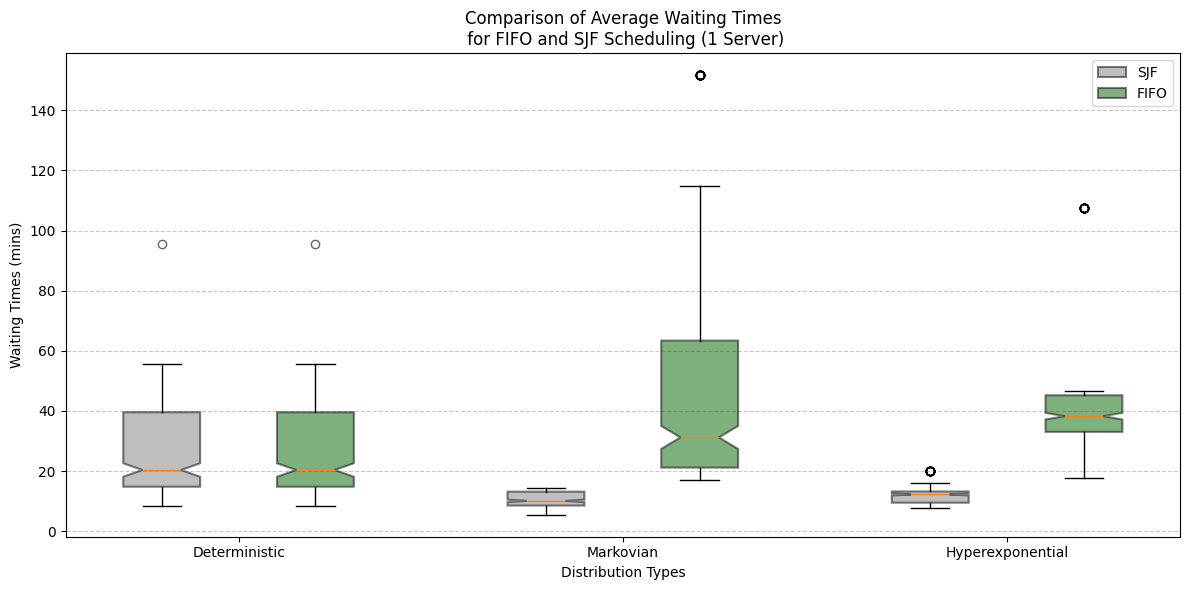

In [ ]:
colors_sjf = ['gray', 'gray', 'gray']  
colors_fifo = ['darkgreen', 'darkgreen', 'darkgreen']  
server_type = "1 Server"  
average_waiting_times_sjf_deterministic = results_sjf["Deterministic"][1]
average_waiting_times_sjf_hyperexponential = results_sjf["Hyperexponential"][1]
average_waiting_times_sjf_markovian = results_sjf["Markovian"][1]

average_waiting_times_fifo_deterministic = results["Deterministic"][1]
average_waiting_times_fifo_hyperexponential = results["Hyperexponential"][1]
average_waiting_times_fifo_markovian = results["Markovian"][1]

average_waiting_times_sjf = [
    average_waiting_times_sjf_deterministic,
    average_waiting_times_sjf_hyperexponential,
    average_waiting_times_sjf_markovian
]

average_waiting_times_fifo = [
    average_waiting_times_fifo_deterministic,
    average_waiting_times_fifo_hyperexponential,
    average_waiting_times_fifo_markovian
]

labels = ["Deterministic", "Markovian", "Hyperexponential"]

plt.figure(figsize=(12, 6))

positions_sjf = [1, 3, 5]  
bp_sjf = plt.boxplot(
    average_waiting_times_sjf,
    positions=positions_sjf,
    patch_artist=True,
    notch=True,
    widths=0.4,
    boxprops=dict(linewidth=1.5),
    labels=labels,
    flierprops=dict(marker='o', color='red', alpha=0.6, markersize=6)
)

for patch, color in zip(bp_sjf["boxes"], colors_sjf):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

positions_fifo = [x + 0.8 for x in positions_sjf]  
bp_fifo = plt.boxplot(
    average_waiting_times_fifo,
    positions=positions_fifo,
    patch_artist=True,
    notch=True,
    widths=0.4,
    boxprops=dict(linewidth=1.5),
    flierprops=dict(marker='o', color='red', alpha=0.6, markersize=6)
)
for patch, color in zip(bp_fifo["boxes"], colors_fifo):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

plt.title("Comparison of Average Waiting Times\n for FIFO and SJF Scheduling (1 Server)")
plt.ylabel("Waiting Times (mins)")
plt.xlabel("Distribution Types")
plt.xticks([(sjf + fifo) / 2 for sjf, fifo in zip(positions_sjf, positions_fifo)], labels)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend([bp_sjf["boxes"][0], bp_fifo["boxes"][0]], ["SJF", "FIFO"], loc="upper right")
plt.tight_layout()
plt.savefig("comparison_boxplot_sjf_fifo_1server.png", dpi=300)
plt.show()